In [1]:
# Imports
#%matplotlib qt
%matplotlib inline
import sys
import os
import numpy as np

import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from matplotlib import cm
import scipy
from collections import Counter

import mne
from fooof import FOOOF
from fooof import FOOOFGroup
from fooof.analysis import *

In [2]:
fg = FOOOFGroup()

In [3]:
# Set up paths

# This base path will need updating
base_path = 'D:\\abc\\Documents\\Research\\rtPB_Data'

# These should stay the same
#subj_dat_fname = '._35**_resampled.set'
subj_dat_fname = '3512_resampled.set'

In [4]:
ev_dict = {
    # Recording Blocks
    'Filt Labelling': 1000,
    'Thresh Labelling Block': 1001,
    
    # Instruction Blocks
    'Start Labelling Block':2000,
    'End Labelling Block': 2001,
    
    # Rest Blocks 
    'Start Block':3000,
    'End Block':3001,
    
    # Trial Markers
    'Label_Peak_filt': 4000,
    'Label_Trough_filt':4001,
    'Markers0':4002,
    'Markers1' :4002,
    'MissTrial':4003,
    'HitTrial':4004
}

In [5]:
# Read in subject listed above
full_path = os.path.join(base_path, subj_dat_fname)
eeg_dat = mne.io.read_raw_eeglab(full_path, event_id_func=None, preload=True)

<ipython-input-5-d91f2579a730>:3: DeprecationWarning: stim_channel (default True in 0.17) will change to False in 0.18 and be removed in 0.19, set it to False in 0.17 to avoid this warning
  eeg_dat = mne.io.read_raw_eeglab(full_path, event_id_func=None, preload=True)


Reading D:\abc\Documents\Research\rtPB_Data\3512_resampled.fdt
Reading 0 ... 1750854  =      0.000 ...  3501.708 secs...
Used Annotations descriptions: []
Returning empty stim channel. Some annotations werefound but dropped during build of the raw.Please use `event_id` and `event_id_func` to drivethe selection/rejection of events


<ipython-input-5-d91f2579a730>:3: RuntimeWarning: 3178/3178 event codes could not be mapped to integers. Use the 'event_id' parameter to map such events manually.
  eeg_dat = mne.io.read_raw_eeglab(full_path, event_id_func=None, preload=True)


In [6]:
evs = mne.io.eeglab.read_events_eeglab(full_path, ev_dict)

C:\Users\abc\Anaconda3\lib\site-packages\mne\utils.py:876: DeprecationWarning: Function read_events_eeglab is deprecated; read_events_eeglab is deprecated from 0.17 and will be removed in 0.18. Please use read_annotations and create events using events_from_annotations.
  warnings.warn(msg, category=DeprecationWarning)
<ipython-input-6-e55b000d48b3>:1: RuntimeWarning: Events like the following will be dropped entirely: ['Sham_Pres_train', 'Label_Fall_filt', 'Undetected_Pres_thresh', 'Thresh Labelling', 'DECIMAL released'], 32 in total
  evs = mne.io.eeglab.read_events_eeglab(full_path, ev_dict)
<ipython-input-6-e55b000d48b3>:1: RuntimeWarning: 1706/3178 event codes could not be mapped to integers. Use the 'event_id' parameter to map such events manually.
  evs = mne.io.eeglab.read_events_eeglab(full_path, ev_dict)


In [7]:
new_evs = np.empty(shape=(0, 3))
#for ev_code in [2000, 3000]:
for ev_label in ['Start Labelling Block', 'Start Block']:
    ev_code = ev_dict[ev_label]
    temp = evs[evs[:, 2] == ev_code]
    new_evs = np.vstack([new_evs, temp])

In [8]:
Counter(evs[:, 2])
#new_evs
# Sanity check
# evs[evs[:, 2] == 5000]

Counter({1: 2,
         0: 242,
         7: 2,
         5: 2,
         1000: 1,
         2000: 2,
         4001: 21,
         4000: 26,
         2001: 2,
         4002: 216,
         4004: 373,
         4003: 323,
         3000: 10,
         10: 240,
         3001: 10})

In [9]:
eeg_dat.add_events(new_evs)

In [10]:
Counter(eeg_dat._data[-1, :])

Counter({0.0: 1750843, 2000.0: 2, 3000.0: 10})

In [11]:
eeg_dat.set_eeg_reference()
# set EEG average reference

Applying average reference.
Applying a custom EEG reference.


<RawEEGLAB  |  3512_resampled.fdt, n_channels x n_times : 65 x 1750855 (3501.7 sec), ~868.4 MB, data loaded>

In [12]:
# identifying all the events and IDs
mne.find_events(eeg_dat);

12 events found
Event IDs: [2000 3000]


In [13]:
events = mne.find_events(eeg_dat)
event_id = {'Start Labelling Block':2000, 'Start Block': 3000}
epochs = mne.Epochs(eeg_dat, events=events, event_id=event_id)

12 events found
Event IDs: [2000 3000]
12 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated


Loading data for 12 events and 351 original time points ...
0 bad epochs dropped
Loading data for 12 events and 351 original time points ...


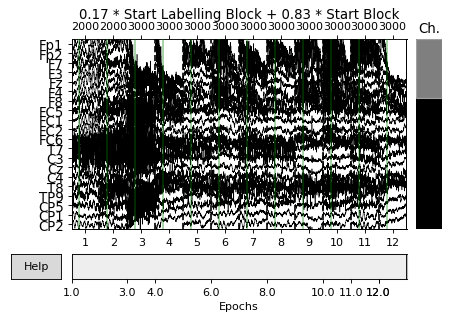

In [14]:
epochs.plot();

# Marking bad channels
### Based on visualization.


In [15]:
eeg_dat.info['bads'] = ['TP9']

In [16]:
print('Bad channels: ', eeg_dat.info['bads'])

Bad channels:  ['TP9']


12 events found
Event IDs: [2000 3000]
Found %s events.



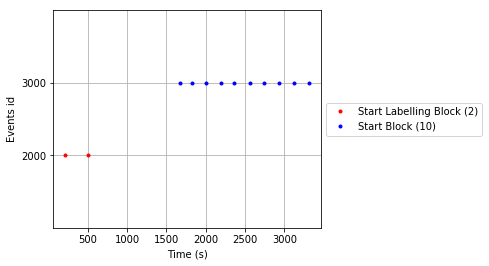

In [17]:
events = mne.find_events(eeg_dat)
print('Found %s events.')
print()

# Plot the events to get an idea of the paradigm
# Specify colors and an event_id dictionary for the legend.
# Plotting only Start and Rest Block events
event_id = {'Start Labelling Block':2000, 'Start Block': 3000}
color = {2000:'red', 3000:'blue'}

mne.viz.plot_events(events, eeg_dat.info['sfreq'], eeg_dat.first_samp, color=color,
                    event_id=event_id);

# Marking bad moments
### Identifying bad moments based on visualization

In [18]:
# Not to critical for this data

In [19]:
epochs = mne.Epochs(eeg_dat, events=events, event_id=event_id, tmin = 5, tmax = 125,
                    baseline = None)

12 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated


In [20]:
chs = mne.channels.read_montage('standard_1020', epochs.ch_names[:-1])
epochs.set_montage(chs)

<Epochs  |   12 events (good & bad), 5 - 125 sec, baseline off, ~162 kB, data not loaded,
 'Start Block': 10
 'Start Labelling Block': 2>

In [21]:
epochs.drop_bad()

Loading data for 12 events and 60001 original time points ...
0 bad epochs dropped


<Epochs  |   12 events (all good), 5 - 125 sec, baseline off, ~162 kB, data not loaded,
 'Start Block': 10
 'Start Labelling Block': 2>

Loading data for 12 events and 60001 original time points ...


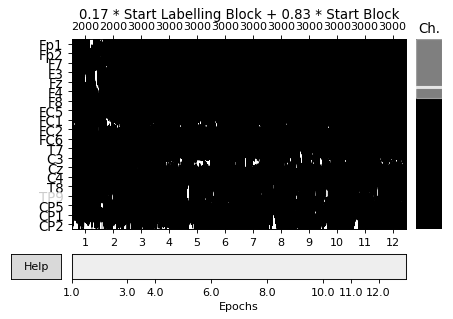

In [22]:
epochs.plot();

In [26]:
# Calculate PSDs
psd, freqs = mne.time_frequency.psd_welch(epochs, fmin=1., fmax=50., n_fft=2000, n_overlap=250, n_per_seg=500)


Loading data for 12 events and 60001 original time points ...
Effective window size : 4.000 (s)


In [24]:
# Get freq res of PSD
f_res = np.mean(np.diff(freqs))

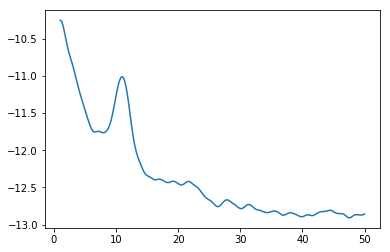

In [27]:
plt.plot(freqs, np.log10(psd[3, 30, :]))

# FOOOFing Data

In [28]:
fooof_psd = np.squeeze(psd[4,:,:])

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 3 - 32 Hz                        
                                 Frequency Resolution is 0.25 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -11.0992, 1.0794                                         
                                                                                                  
                                       4 peaks were found:                                        
          

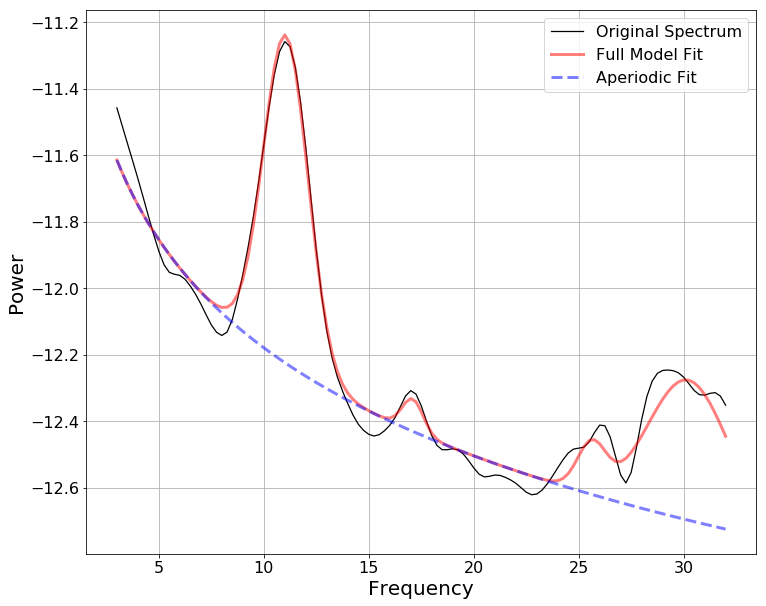

In [29]:
# Initialzing FOOOF model
fm = FOOOF(peak_width_limits=[1, 6], min_peak_height=0.075, max_n_peaks=6, peak_threshold=1)

# Setting frequency range
freq_range = [3, 32]

fm.report(freqs, fooof_psd[40, :], freq_range)

In [30]:
# Run FOOOF across a group of PSDs
fg = FOOOFGroup(verbose=False)
fg.fit(freqs, fooof_psd, freq_range)

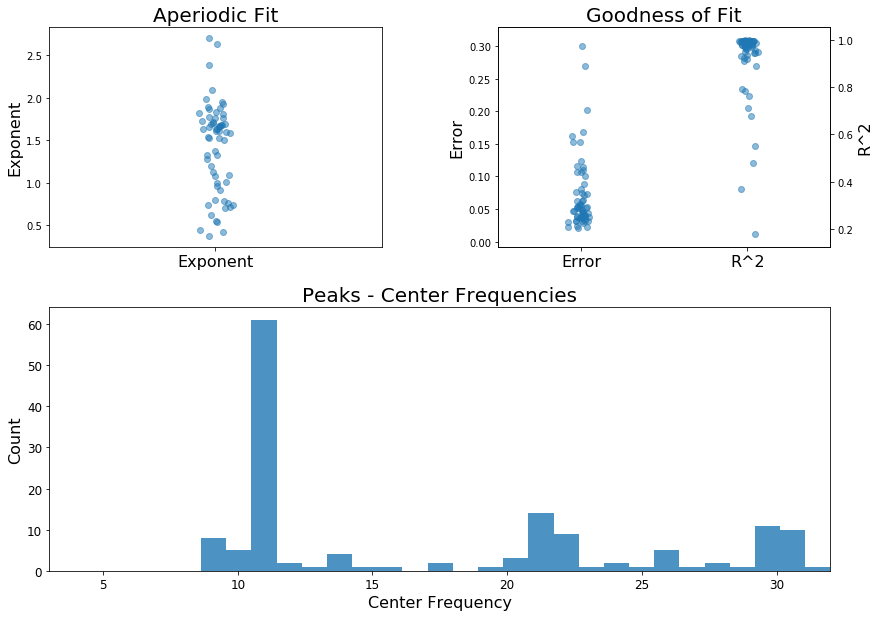

In [31]:
fg.plot()

In [32]:
n_channels, n_freq = fooof_psd.shape

In [33]:
fooof_results = np.zeros(shape = [n_channels,3])

In [34]:
for i, ch_dat in enumerate(fg.group_results):
    fooof_results[i,:] = get_band_peak(ch_dat.peak_params, [8, 12])

In [35]:
cfs = fooof_results[:, 0]
amps = fooof_results[:, 1]
bws = fooof_results[:,2]

In [36]:
cfs = np.nan_to_num(cfs)
amps = np.nan_to_num(amps)
bws = np.nan_to_num(bws)

In [37]:
# Define our oscillation bands
bands = [['Theta', [4, 8]], ['Alpha', [8, 12]]]

In [38]:
# DESIRED OUTPUT:
#  1d array, len of n_channels with osc_band freq for each channel
#  Note: deal with the band in channel: try out different markers for none (0, nan, etc.)

# Mapping

In [39]:
montage = mne.channels.read_montage('standard_1020', epochs.ch_names[:-1])
epochs.set_montage(montage)

<Epochs  |   12 events (all good), 5 - 125 sec, baseline off, ~162 kB, data not loaded,
 'Start Block': 10
 'Start Labelling Block': 2>

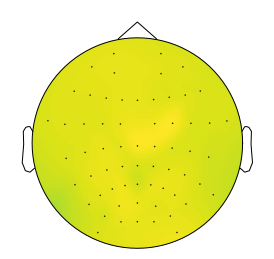

In [40]:
mne.viz.plot_topomap(cfs, epochs.info, cmap=cm.viridis, contours=0);

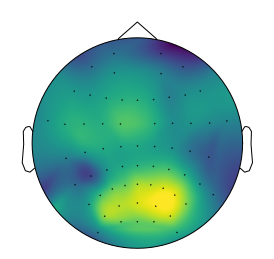

In [41]:
mne.viz.plot_topomap(amps, epochs.info, cmap=cm.viridis, contours=0);

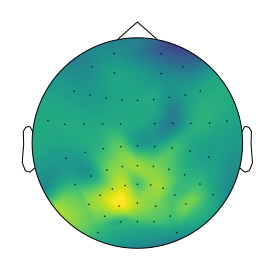

In [42]:
mne.viz.plot_topomap(bws, epochs.info, cmap=cm.viridis, contours=0);